In [2]:
#TODO Ustaw niezbędne ścieżki
# wybierz parametry zależnie od możliwości sprzętowych
# sprawdź czy dane pobrały się poprawnie.
 
# TODO Set the necessary paths
# Choose parameters depending on hardware capabilities
# Check if the data has been downloaded correctly.
 
import os
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3 # Object, background, uncertain area between
batch_size = 8
input_img_paths = [input_dir + f_name for f_name in os.listdir(input_dir)] # folder + file path
target_img_paths = [target_dir + f_name for f_name in os.listdir(target_dir) if not f_name.startswith(".")]

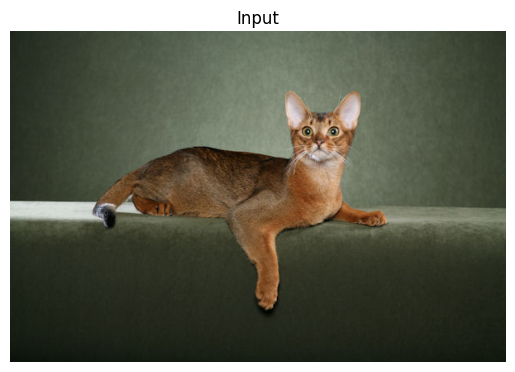

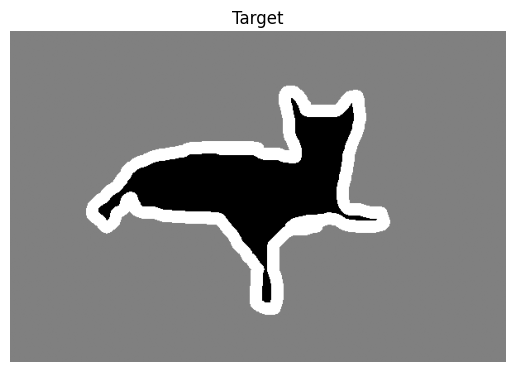

In [6]:
import matplotlib.pyplot as plt

input_example = plt.imread(input_img_paths[0])
plt.imshow(input_example)
plt.title("Input")
plt.axis('off')
plt.show()

target_example = plt.imread(target_img_paths[0])
plt.imshow(target_example, cmap="gray")
plt.title("Target")
plt.axis('off')
plt.show()

In [8]:
# TODO Aby nasza własna funkcja działa jak generator i mogła być używana np. przez fit musi mieć trzy definicje: init, len i getitem
# For our custom function to function as a generator and be usable, for example, by fit, it must have three definitions: __init__, __len__, and __getitem__.

import numpy as np
from tensorflow import keras


class DataGen(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    # Ile batchy
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
 
    def __getitem__(self, batch_idx):
        """Returns tuple (input, target) correspond to batch #idx."""

        batch_input_paths = self.input_img_paths[batch_idx * self.batch_size : (batch_idx + 1) * self.batch_size]
        batch_target_paths = self.target_img_paths[batch_idx * self.batch_size : (batch_idx + 1) * self.batch_size]
        
        input_batch = np.zeros((self.batch_size,) + self.img_size + (3,), dtype=np.float32)
        target_batch = np.zeros((self.batch_size,) + self.img_size + (3,), dtype=np.uint8)
        
        for i, (input_path, target_path) in enumerate(zip(batch_input_paths, batch_target_paths)):
             input_batch[i] = plt.imread(input_path)
             target_img = plt.imread(target_path)
             target_img = np.expand_dims(target_img, 2)
             target_img -= 1
             target_batch[i] = target_img
        
        return input_batch, target_batch

In [10]:
from tensorflow.keras import layers
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [11]:
import tensorflow as tf
def get_model(img_size, num_classes):
    inputs = layers.Input(shape=(*img_size, 3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model
keras.backend.clear_session()
model = get_model(img_size, num_classes)

In [12]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 160, 160,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 160, 160,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 80, 80,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 80, 80,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 80,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 80, 80,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 40, 40,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 40,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 40, 40,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 40, 40,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 20, 20,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 20, 20,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 20, 20,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 20, 20,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 10, 10,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 10, 10,    │          0 │ max_pooling2d_3[

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# TODO Podziel dane na zbiory treningowy i walidacyjny (na bazie ścieżek)
# TODO: Divide the data into training set and validation set (based on paths)
import random

val_samples = 1000

random.Random().shuffle(input_img_paths)
random.Random().shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_gen = DataGen(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = DataGen(batch_size, img_size, val_input_img_paths, val_target_img_paths)

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("unet.h5", save_best_only=True)]
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen,callbacks=callbacks)